<a href="https://colab.research.google.com/github/haneulllll/DataStudy/blob/main/%EB%B3%B5%EC%8A%B5_%EC%9D%B4%ED%95%9C%EC%9D%8486_0714.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **< 시계열분석 >**



사용하는 데이터 : walmart_cleaned.csv => 월마트 데이터

**Store**: 매장 ID

**Date**: 기록날짜

**Dept**: 부서 ID

**Weekly_Sales**: 특정 주에 해당 매장에서 발생한 총 매출

**IsHoliday**: 공휴일 여부

**Temperature**: 지역의 평균 기온

**Fuel_Price**: 지역의 평균 연료 가격

**CPI (Consumer Price Index)**: 소비자 물가지수

**Unemployment**: 지역의 실업률

**Type**: 매장의 유형

**Size**: 매장의 크기

In [ ]:
!pip install pmdarima

In [ ]:
# 라이브러리 불러오기
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

**1. 선형회귀로 예측하기**

1. 데이터 나누기 ( 종속변수와 독립변수로 분리 )
2. 데이터 나누기 ( train용 / test용 )
3. 모델 학습

In [ ]:
# 학습(train)을 위하여 추가적인 데이터(밀린 데이터)를 생성
data_statistic['Weekly_Sales_1w'] = data_statistic['Weekly_Sales'].shift(1)
data_statistic['Weekly_Sales_2w'] = data_statistic['Weekly_Sales'].shift(2)
data_statistic['Weekly_Sales_3w'] = data_statistic['Weekly_Sales'].shift(3)
data_statistic['Weekly_Sales_4w'] = data_statistic['Weekly_Sales'].shift(4)

data_statistic = data_statistic.dropna()


# 독립변수(x), 종속변수(y) 분리
x = data_statistic.drop(['Weekly_Sales','Date'], axis=1)
y = data_statistic['Weekly_Sales']

In [ ]:
# train,test 데이터 나누기

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=111)

In [ ]:
model = LinearRegression(fit_intercept=True)
model.fit(x_train, y_train) # 모델 학습

y_predict = model.predict(x_test) # 예측

In [ ]:
print('train 데이터의 실제값-예측값 R-square : {:.5f}'.format(model.score(x_train, y_train)))
print('test 데이터의 실제값-예측값 R-square : {:.5f}'.format(model.score(x_test, y_test)))

train 데이터의 실제값-예측값 R-square : 0.18608
test 데이터의 실제값-예측값 R-square : 0.13551


**ADF 검정 (p-value)**

In [ ]:
# p-value < 0.05 => 대립가설 채택, 귀무가설 기각 => 정상성 테스트
def ADF(ts_temp) :
  res = adfuller(ts_temp)
  print('ADF Test')
  print('ADF Statistic: %f' % res[0])
  print('p-value: %f' % res[1])
  print('Lag: %d' % res[2])
  print('Observation %d' % res[3])
  print('Critical Values:')
  for key, value in res[4].items():
    print('\t%s: %.3f' % (key, value))

In [ ]:
ADF(new)

ADF Test
ADF Statistic: -5.361173
p-value: 0.000004
Lag: 4
Observation 138
Critical Values:
	1%: -3.479
	5%: -2.883
	10%: -2.578


**ARIMA로 예측하기**

In [ ]:
new

,Weekly_Sales
Date,
2010-02-05,9848117.18
2010-02-12,9825819.17
2010-02-19,9549228.71
2010-02-26,8654668.75
2010-03-05,9195207.32
...,...
2012-09-28,7805781.97
2012-10-05,8689556.65
2012-10-12,8305854.58


In [ ]:
train = new.loc['2010-02-05':'2012-09-30']
test = new.loc['2012-10-01':'2012-10-26']

print(len(train))
print(len(test))

139
4


In [ ]:
# ARIMA 모델 이용

p,d,q = 2, 0, 2
model = ARIMA(train['Weekly_Sales'], order=(p,d,q))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


In [ ]:
# 모델 Training
model_fit = model.fit()

# 예측
result = model_fit.forecast(steps=4)
result = pd.Series(result, index = test.index)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<Axes: xlabel='Date', ylabel='Weekly_Sales'>

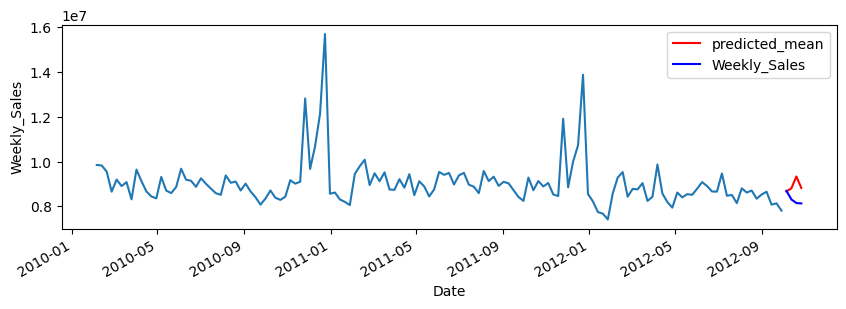

In [ ]:
# 시각화를 통한 Validation
fig,ax = plt.subplots(figsize=(10,3))
grp = sns.lineplot(x='Date', y=train['Weekly_Sales'], data=train)
result.plot(ax=ax, color='r',legend=True)
test.plot(ax=ax, color='b',legend=True)

**Auto-ARIMA로 예측하기**
- Auto-Arima(데이터셋, seasonal=True)
=> 계절성을 반영할 수 있는 장점

<Axes: xlabel='Date', ylabel='Weekly_Sales'>

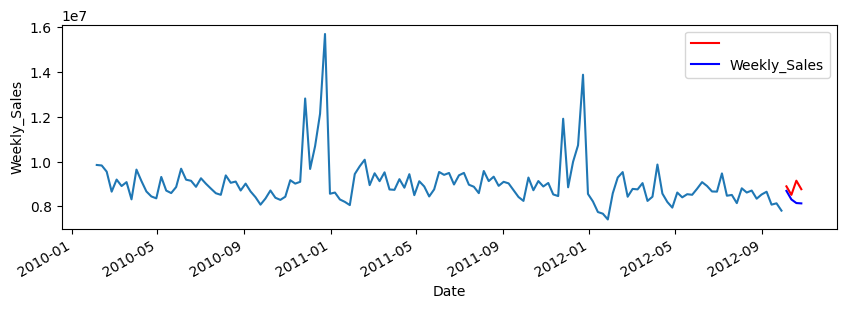

In [72]:
auto_model = pm.auto_arima(train, seasonal=True, m=52)
auto_model

# 예측
auto_predict = auto_model.predict(4)
auto_predict = pd.Series(auto_predict, index= test.index)

fig,ax = plt.subplots(figsize=(10,3))
grp = sns.lineplot(x='Date', y='Weekly_Sales',data=train)
auto_predict.plot(ax=ax, color='red', legend=True)
test.plot(ax=ax, color='blue', legend=True)

# **< 문자열 데이터 분석 >**

**re module을 이용하여 문자열 데이터 분석**

In [74]:
import re

**정규 표현식**

- 숫자 [0-9] /d
- 영어소문자[a-z]
- 영어대문자[A-Z]
- 한글[가-힣]
- 자음, 모음 다 가능
- ^ not
- *, + 패턴찾기!

In [75]:
# 문자열에서 첫번째 숫자를 검색
re.search('[0-9]','1231322456373521,dsafesaefa!@#223')

<re.Match object; span=(0, 1), match='1'>

In [76]:
# 문자열에서 연속되는 숫자를 검색
re.search('[0-9]+','1231322456373521,dsafesaefa!@#223')

<re.Match object; span=(0, 16), match='1231322456373521'>

In [77]:
# 문자열이 ###-####-### 형식인지 확인
re.match('[0-9]{3}-[0-9]{4}-[0-9]{4}','010-1234-5678')

<re.Match object; span=(0, 13), match='010-1234-5678'>